# Data description & Problem statement: 
The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes. Please check the description at: https://archive.ics.uci.edu/ml/datasets/auto+mpg

* The data has 398 rows and 9 variables.
* This is a Regression problem. We predict the Auto MPG.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial SVM model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of SVM model: Find the best SVM model 
   # Model Evaluation: 
- Evaluate the best SVM model with optimized hyperparameters on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/mpg/mpg.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [3]:
df['horsepower'] = df['horsepower'].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.drop(['name' ], axis=1, inplace=True)

In [4]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
for name in ['origin']:
    encode_text_dummy(df, name)
    
df.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin-1,origin-2,origin-3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0


In [5]:
X=df.drop(['mpg'], axis=1)
y=np.log(df['mpg'])

# Re-scaling:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [6]:
# We build the Initial Model & Cross-Validation:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model=SVR()
kfold=KFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.86630858 0.90337921 0.86644419 0.87233376 0.86739805] 

Accuracy: 0.88 (+/- 0.01)


In [7]:
# Grid-Serach for the best model parameters: 
from sklearn.model_selection import GridSearchCV

param={'kernel':['rbf'], 'C': [0.1, 1, 5, 7, 10, 100, 1000, 2000, 5000], 'gamma':[0.0001, 0.001, 0.01, 0.1, 0.5, 2, 5, 10]}

kfold=KFold(n_splits=4, shuffle=True, random_state=42)
grid_search=GridSearchCV(SVR(), param, cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,0.00150,0.000503,0.000246,0.000425,1,0.5,rbf,"{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}",0.856758,0.920222,...,0.898767,0.891481,0.022882,1,0.917133,0.908931,0.907814,0.912086,0.911491,0.003615
58,0.00748,0.001115,0.000000,0.000000,2000,0.01,rbf,"{'C': 2000, 'gamma': 0.01, 'kernel': 'rbf'}",0.867198,0.909057,...,0.896756,0.890392,0.015274,2,0.915338,0.907544,0.904333,0.909775,0.909248,0.004013
20,0.00374,0.000431,0.000249,0.000431,5,0.5,rbf,"{'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}",0.860902,0.910581,...,0.893137,0.889058,0.017939,3,0.920492,0.912506,0.907172,0.915764,0.913983,0.004851


In [8]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
Best validation accuracy:  0.89 (+/- 0.02)
Test score:  0.87


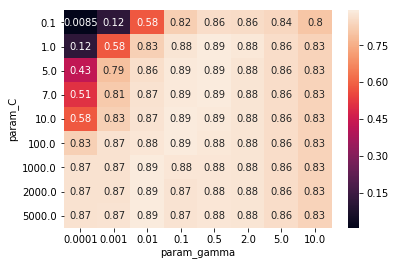

In [9]:
h=G[["param_C", "param_gamma", "mean_test_score"]].pivot_table(index="param_C", columns="param_gamma", values="mean_test_score")
sns.heatmap(h, annot=True)

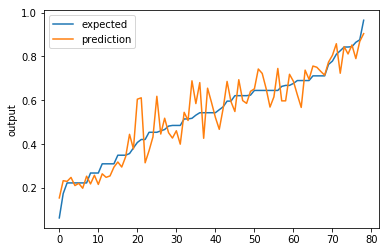

In [10]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2.656182106207506


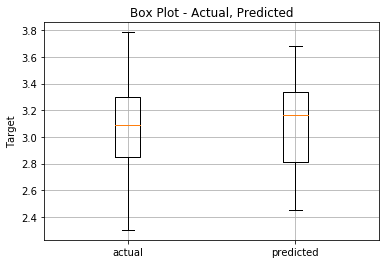

In [12]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

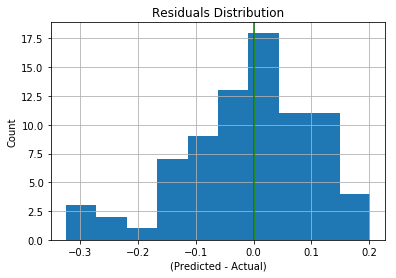

In [13]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()